<h1>Calculating the Power Spectrum Slope and Narrowband Theta Power</h1>

<blockquote style="font-size: 12;">
<pre>
This tutorial will show you how to calculate the PSS and narrowband theta power from your raw lfp data. <br>
</pre>
</blockquote>

In [28]:
import pynapple as nap
from PSS import spec, logsubsample, spec_slope, narrowbandTheta, getPSS, getTheta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

<blockquote style="font-size: 12;">
<pre>
Let's first calculate the PSS. <br>
We will start by loading the lfp signal, using the pynapple function <i>load_eeg</i>. <br>
Channel 25 specifies the SW channel, previously chosen as a channel with prominent slow waves. <br>
</pre>
</blockquote>

In [29]:
data_directory = '/Users/alissiadimaria/Desktop/20140526_277um_filesToLoad/20140526_277um.lfp'
lfp_SW = nap.load_eeg(data_directory, channel=25)

<blockquote style="font-size: 12;">
<pre>
Now, let's calculate the PSS for the first 1000 seconds of the lfp recording. <br> 
You can specify any of the following default parameters: <br>
winsize=2         # spectrogram window size <br>
dt_spec=1         # time step <br>
window='hann'     # for spectrogram calculation (linearly spaced) <br>
numlogfreqs=200   # to get logarithmically spaced spectrogram <br>
rolling_winsize=5 # smoothing window size <br>
start=None        # start time <br>
end=None          # end time <br>
minimum=2         # min frequency <br>
maximum=20        # max frequency <br>
</pre>
</blockquote>

In [30]:
SWslopes, SWspectrogram = getPSS(lfp_SW, start=0, end=1000)

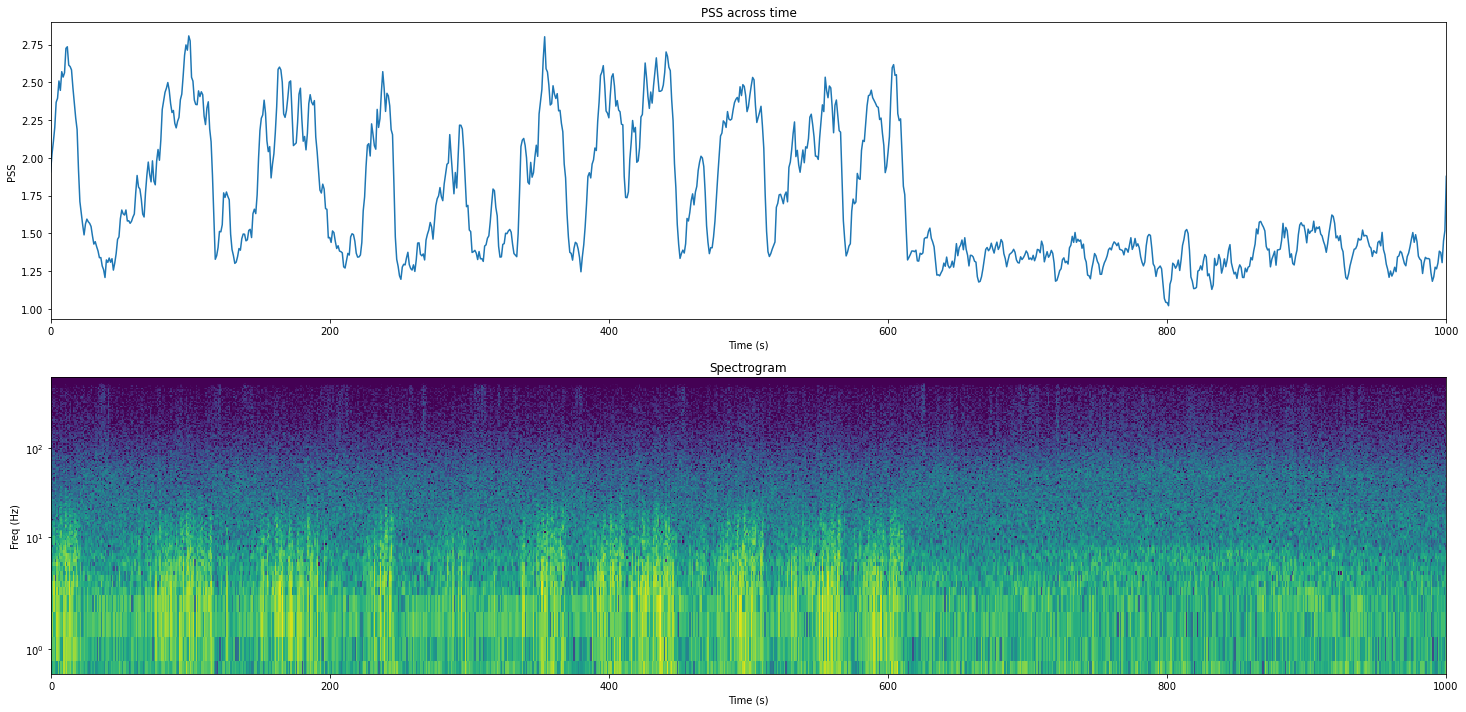

In [31]:
plt.figure(figsize=(40, 10))

plt.subplot(2,2,1)
plt.plot(SWslopes.times(), SWslopes.data())
plt.ylabel('PSS')
plt.xlabel('Time (s)')
plt.title('PSS across time')
plt.xlim(0, 1000)

plt.subplot(2,2,3)
plt.pcolormesh(SWspectrogram.times(), SWspectrogram.columns, np.log10(SWspectrogram.data().T), shading='auto', vmin=0)
plt.xlabel('Time (s)')
plt.ylabel('Freq (Hz)')
plt.title('Spectrogram')
plt.yscale('symlog')

plt.tight_layout()
plt.show()


<blockquote style="font-size: 12;">
<pre>
Next, we will calculate the narrowband theta power. <br>
Again, let's load the lfp signal. <br>
Channel 95 specifies the theta channel, previously chosen as a channel with a high theta power ratio. <br>
</pre>
</blockquote>

In [32]:
lfp_theta = nap.load_eeg(data_directory, channel=95)

In [33]:
thetaPower, THspectrogram = getTheta(lfp_theta, start=0, end=1000)

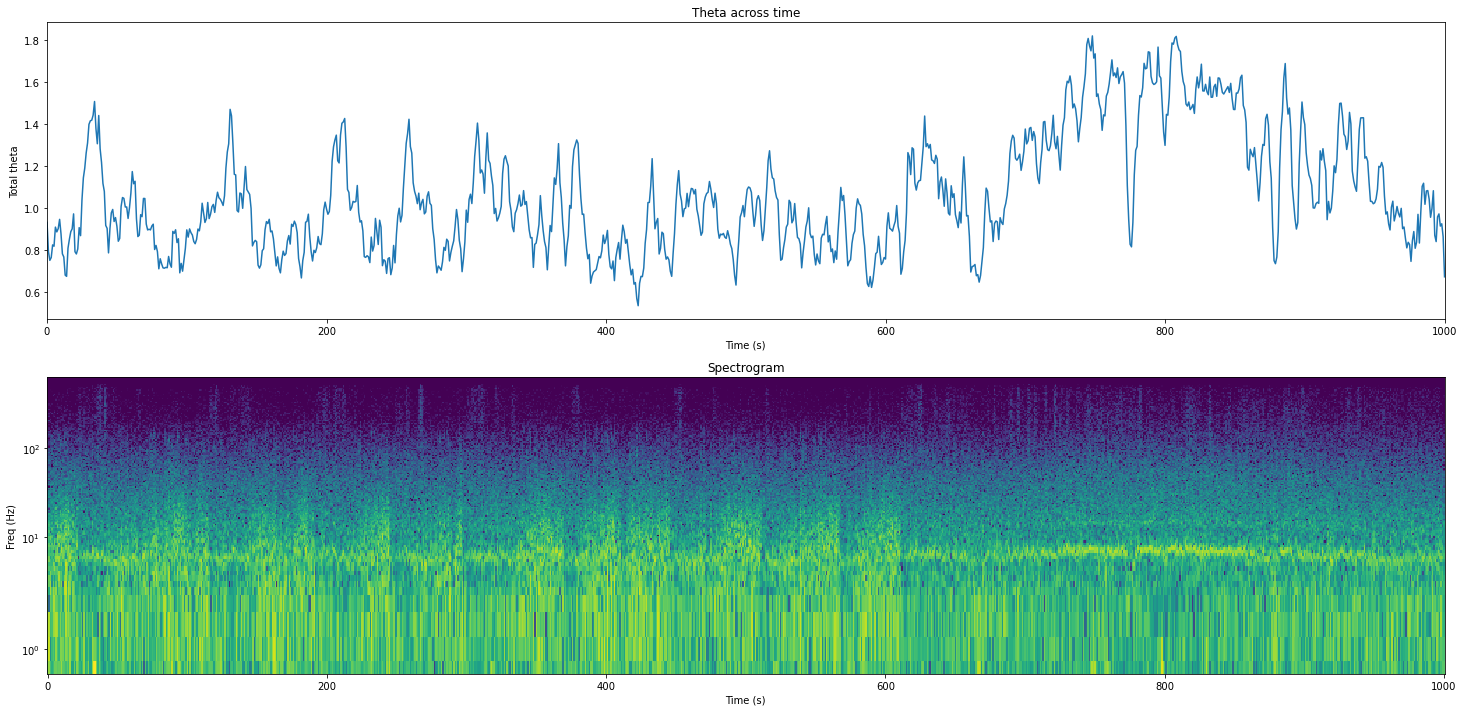

In [34]:
plt.figure(figsize=(40, 10))
plt.subplot(2,2,1)
plt.plot(thetaPower.times(), thetaPower.data())
plt.xlabel('Time (s)')
plt.ylabel('Total theta')
plt.title('Theta across time')
plt.xlim(0, 1000)

plt.subplot(2,2,3)
plt.pcolormesh(THspectrogram.times(), THspectrogram.columns, np.log10(THspectrogram.data().T), shading='auto', vmin=0)
plt.xlabel('Time (s)')
plt.ylabel('Freq (Hz)')
plt.title('Spectrogram')
plt.yscale('symlog')

plt.tight_layout()
plt.show()

<blockquote style="font-size: 12;">
<pre>
Great, we are done! <br>
From here you will be able to compute the histograms of the PSS and narrowband theta power to divide the data into NREM, REM, and WAKE epochs. <br>

Using the sub-functions within <i>getPSS</i> and <i>getTheta</i>, let's take a look at some plots! <br>
</pre>
</blockquote>

<blockquote style="font-size: 12;">
<pre>
We will start by computing the spectrogram using <i>spec</i>, after which we will call <i>logsubsample</i> to go from linearly spaced to logarithmically spaced frequencies. <br>

We then need to compute the slopes of the individual power spectra. We will call <i>spec_slope</i> and specify a frequency range of 4 to 100 Hz, which outputs the following: <br>
slopesTSD     # stores slopes and timestamps in a TSD <br>
residuals     # stores theta residuals, timestamps, and frequencies in a TSD <br>
power4fit     # smoothed power spectra <br>
slopes        # from line of best fit of each power spectrum <br>
intercepts    # from line of best fit of each power spectrum <br>

The latter three outputs will be useful for plotting. <br>
</pre>
</blockquote>

In [35]:
spectrogram_linspacedSW = spec(lfp_SW, winsize=2, dt_spec=1, window='hann', start=0, end=1000)
spectrogramSW = logsubsample(spectrogram_linspacedSW, numlogfreqs=200)

In [36]:
slopesTSD, residualsSW, power4fitSW, slopesSW, interceptsSW = spec_slope(spectrogramSW, minimum=4, maximum=100)

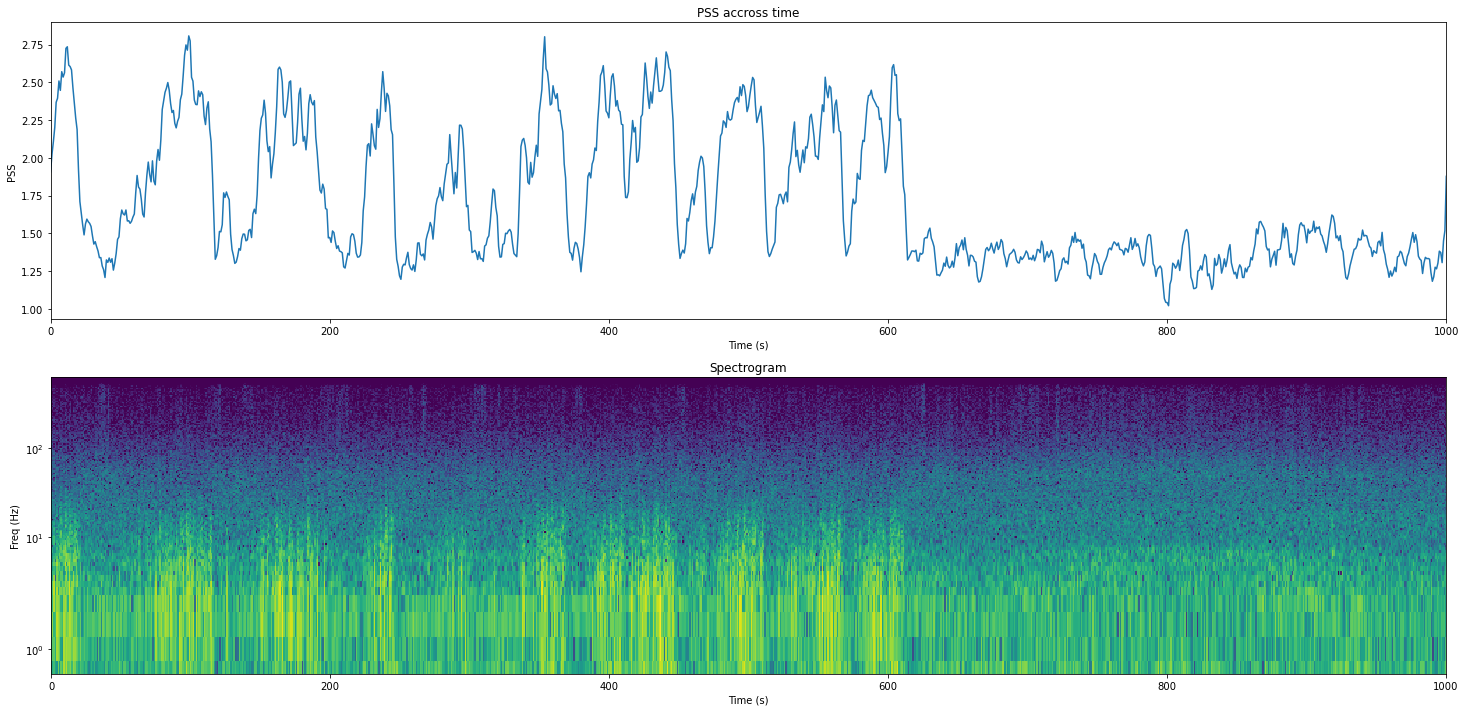

In [37]:
plt.figure(figsize=(40, 10))
plt.subplot(2,2,1)
plt.plot(slopesTSD.times(), slopesTSD.data())
plt.xlabel('Time (s)')
plt.ylabel('PSS')
plt.title('PSS accross time')
plt.xlim(0,1000)

plt.subplot(2,2,3)
plt.pcolormesh(spectrogramSW.times(), spectrogramSW.columns, np.log10(spectrogramSW.data().T), shading='auto', vmin=0)
plt.xlabel('Time (s)')
plt.ylabel('Freq (Hz)')
plt.title('Spectrogram')
plt.yscale('symlog')

plt.tight_layout()
plt.show()

<blockquote style="font-size: 12;">
<pre>
Notice at timepoint 600, PSS is high, whereas at timepoint 800, PSS is low. Let's take a closer look! <br>
*High PSS (steeper slope) = NREM <br>
*Low PSS (shallower slope) = REM, WAKE <br>
</pre>
</blockquote>

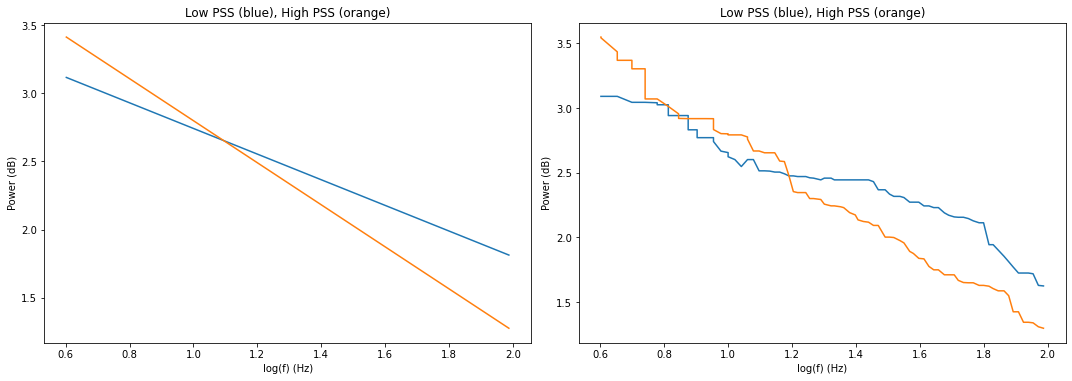

In [38]:
timepoint_high = 600 
timepoint_low = 800 
x = np.log10(residualsSW.columns) # frequency values 

y_low = power4fitSW[timepoint_low, :] # smoothed power spectrum 
y_high = power4fitSW[timepoint_high, :]

yfit_low = slopesSW[timepoint_low] * x + interceptsSW[timepoint_low] # line of best fit 
yfit_high = slopesSW[timepoint_high] * x + interceptsSW[timepoint_high]

plt.figure(figsize=(15, 10))

plt.subplot(2,2,1)
plt.plot(x, yfit_low) 
plt.plot(x, yfit_high) 
plt.xlabel('log(f) (Hz)')
plt.ylabel('Power (dB)')
plt.title("Low PSS (blue), High PSS (orange)")

plt.subplot(2,2,2)
plt.plot(x, y_low) 
plt.plot(x, y_high) 
plt.xlabel('log(f) (Hz)')
plt.ylabel('Power (dB)')
plt.title("Low PSS (blue), High PSS (orange)")

plt.tight_layout()
plt.show()

<blockquote style="font-size: 12;">
<pre>
We can follow the same process for the narrowband theta power, specifying a frequency range of 2 to 20 Hz. <br>
</pre>
</blockquote>

In [39]:
spectrogram_linspacedTH = spec(lfp_theta, winsize=2, dt_spec=1, window='hann', start=0, end=1000)
spectrogramTH = logsubsample(spectrogram_linspacedTH, numlogfreqs=200)

<blockquote style="font-size: 12;">
<pre>
Here, <i>narrowbandTheta</i> takes the maximum of the theta residuals within a 5 to 10 Hz frequency range for each power spectrum, and outputs a TSD. <br>
</pre>
</blockquote>

In [40]:
_, residualsTH, _, slopesTH, interceptsTH = spec_slope(spectrogramTH, minimum=2, maximum=20)
thetaPower = narrowbandTheta(residualsTH, minTheta=5, maxTheta=10, rolling_winsize=5)

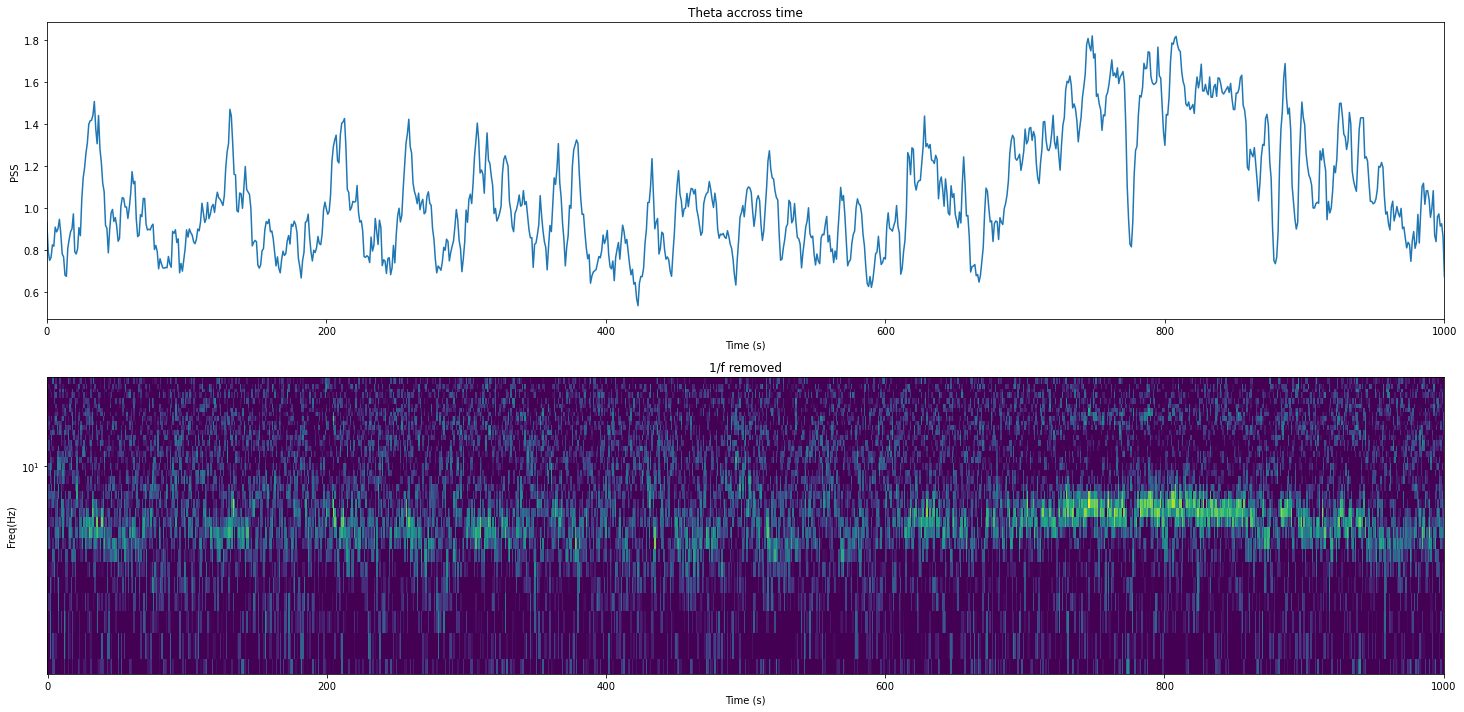

In [41]:
plt.figure(figsize=(40, 10))

plt.subplot(2,2,1)
plt.plot(thetaPower.times(), thetaPower.data())
plt.xlabel('Time (s)')
plt.ylabel('PSS')
plt.title('Theta accross time')
plt.xlim(0,1000)

plt.subplot(2,2,3)
plt.pcolormesh(residualsTH.times(), residualsTH.columns, residualsTH.data().T, shading='auto', vmin=0)
plt.xlabel('Time (s)')
plt.ylabel('Freq(Hz)')
plt.title('1/f removed')
plt.yscale('symlog')

plt.tight_layout()  
plt.show()


<blockquote style="font-size: 12;">
<pre>
Notice at timepoint 800, theta is high, whereas at timepoint 100, theta is low. Again, let's take a closer look! <br>
*High theta = REM <br>
<pre>
</blockquote>

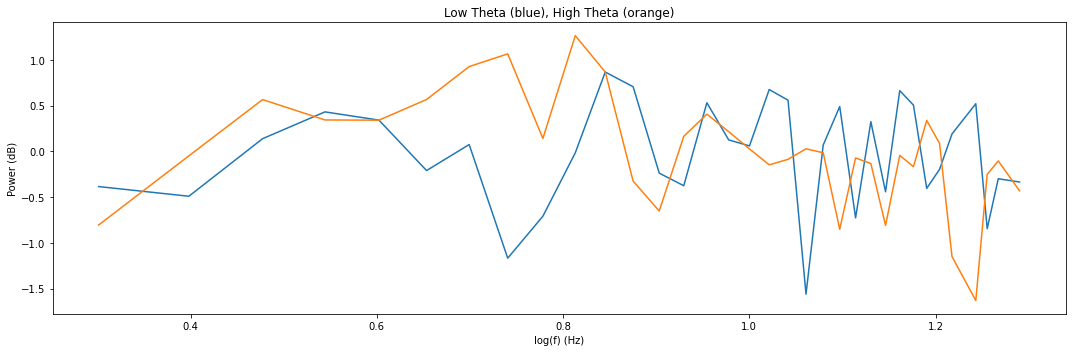

In [42]:
timepoint_high = 800 
timepoint_low = 100 
x = np.log10(residualsTH.columns)

plt.figure(figsize=(15, 5))

plt.plot(x, residualsTH.data()[timepoint_low, :])
plt.plot(x, residualsTH.data()[timepoint_high, :]) 
plt.xlabel('log(f) (Hz)')
plt.ylabel('Power (dB)')
plt.title("Low Theta (blue), High Theta (orange)")

plt.tight_layout()
plt.show()



<blockquote style="font-size: 12;">
<pre>
Finally, let's compute some histograms and a scatter plot. <br>
*High PSS for NREM <br>
*Low PSS for REM, WAKE <br>
*High theta for REM <br>
*Notice the bimodality of the PSS distribution. <br>
*Notice that when PSS is high, theta is low in the scatter plot. Similarly, when theta is high, PSS is low. <br>
<pre>
</blockquote>

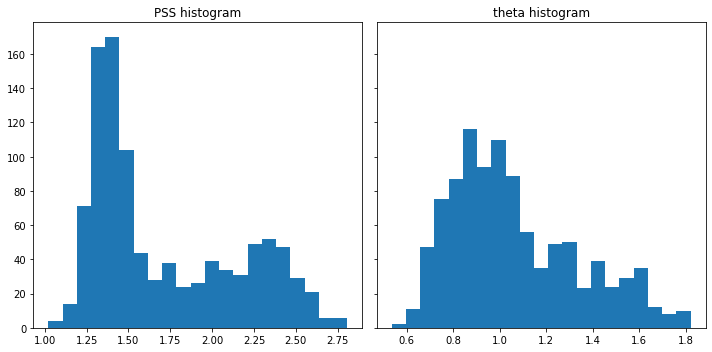

In [43]:
n_bins = 21

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axs[0].hist(slopesTSD.data(), bins=n_bins)
axs[0].set_title('PSS histogram')

axs[1].hist(thetaPower.data(), bins=n_bins)
axs[1].set_title('theta histogram')

plt.tight_layout()
plt.show()

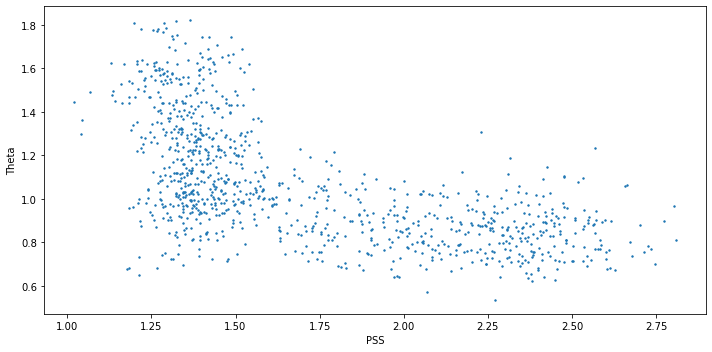

In [44]:
plt.figure(figsize=(10, 5))

plt.scatter(slopesTSD.data(), thetaPower.data(), s=2)
plt.xlabel("PSS")
plt.ylabel("Theta")

plt.tight_layout()
plt.show()